In [1]:
import os

import utils

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import sklearn.metrics
import matplotlib.pyplot as plt

try:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    print("GPU Misconfig")
    exit()

In [2]:
task, num_classes, NN_ARCH, model = utils.setup()

datafolder='./data/ptbxl/'
outputfolder='./output/'

MODELS_DIR = './models/' + NN_ARCH + '_' + str(task)
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

total_params = model.model.count_params()
trainable_count = np.sum([keras.backend.count_params(w) for w in model.model.trainable_weights])

with open(MODELS_DIR + '/' + NN_ARCH + ' records.txt', 'w') as f:
    f.write('---------\n')    
    f.write('Total params:\n')
    f.write(str(total_params) + '\n\n')
    f.write('Trainable params:\n')
    f.write(str(trainable_count) + '\n\n')

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000, 12)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1000, 64)     6208        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1000, 64)     256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 1000, 64)     0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
# Load PTB-XL data
data, raw_labels = utils.load_dataset(datafolder)

# Preprocess label data
labels = utils.compute_label_aggregations(raw_labels, datafolder, task)

# Select relevant data and convert to one-hot
data, labels, Y, _ = utils.select_data(data, labels, task, min_samples=0, outputfolder=outputfolder)

# 1-9 for training 
X_train = data[labels.strat_fold < 10]
y_train = Y[labels.strat_fold < 10]
# 10 for validation
X_val = data[labels.strat_fold == 10]
y_val = Y[labels.strat_fold == 10]

X_train, X_val = utils.preprocess_signals(X_train, X_val)
# print("X_train.shape", X_train.shape)
# print("y_train.shape", y_train.shape)
# print("X_val.shape", X_val.shape)
# print("y_val.shape", y_val.shape)

In [4]:
batch_size=64
epochs=30

if tf.test.is_gpu_available:
    # to ensure GPU use for training   
    history = model.fit(X_train, y_train, batch_size, epochs, MODELS_DIR)
else:
    print('Error in starting training using GPU.')
    exit()

model = keras.models.load_model(MODELS_DIR)

Epoch 1/30
302/302 [==============================] - 11s 37ms/step - loss: 0.1352 - accuracy: 0.9626 - AUC: 0.6617
Epoch 2/30
302/302 [==============================] - 11s 37ms/step - loss: 0.0743 - accuracy: 0.9766 - AUC: 0.7935
Epoch 3/30
302/302 [==============================] - 11s 37ms/step - loss: 0.0683 - accuracy: 0.9779 - AUC: 0.8017
Epoch 4/30
302/302 [==============================] - 12s 38ms/step - loss: 0.0650 - accuracy: 0.9787 - AUC: 0.8105
Epoch 5/30
302/302 [==============================] - 11s 37ms/step - loss: 0.0627 - accuracy: 0.9793 - AUC: 0.8240
Epoch 6/30
302/302 [==============================] - 12s 38ms/step - loss: 0.0610 - accuracy: 0.9797 - AUC: 0.8363
Epoch 7/30
302/302 [==============================] - 12s 39ms/step - loss: 0.0596 - accuracy: 0.9800 - AUC: 0.8434
Epoch 8/30
302/302 [==============================] - 12s 38ms/step - loss: 0.0585 - accuracy: 0.9803 - AUC: 0.8532
Epoch 9/30
302/302 [==============================] - 12s 39ms/step - lo

In [5]:
model = keras.models.load_model(MODELS_DIR)

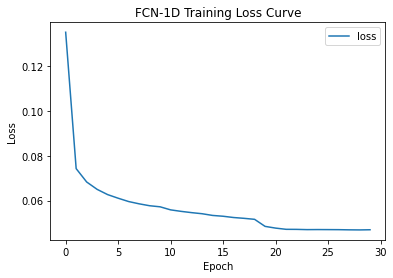

In [6]:
plt.plot(history.history['loss'], label='loss')
plt.title(NN_ARCH + ' Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig(MODELS_DIR + '/' + NN_ARCH + 'Training LOSS')
plt.show()

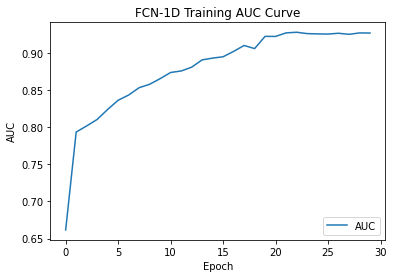

In [7]:
plt.plot(history.history['AUC'], label='AUC')
plt.title(NN_ARCH + ' Training AUC Curve')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(loc='lower right')
plt.savefig(MODELS_DIR + '/' + NN_ARCH + 'Training AUC')
plt.show()

In [8]:
y_val_pred = model.predict(X_val)

In [9]:
import sklearn.metrics

classification_report_resnet = sklearn.metrics.classification_report(y_val, y_val_pred.round(), output_dict=True)

fpr, tpr, threshold = sklearn.metrics.roc_curve(y_val.flatten(), y_val_pred.flatten())
auc = sklearn.metrics.roc_auc_score(y_val,y_val_pred, average='macro')

hamming_loss = sklearn.metrics.hamming_loss(y_val, y_val_pred.round())

# precision, recall, f1_score, _ = sklearn.metrics.precision_recall_fscore_support(y_val, y_val_pred.round(), average='samples')
f1_score = sklearn.metrics.f1_score(y_val,  y_val_pred.round(), average='samples')

print('Tensorflow Original Model')
print(task + ' task')
print('\nAUC:', auc)
print('Hamming Loss:', hamming_loss)
print('F1 Score:', f1_score)

Tensorflow Original Model
diagnostic task

AUC: 0.9175552965534544
Hamming Loss: 0.01971167990585466
F1 Score: 0.6226096911256411
/home/iroh/.conda/envs/eee-198/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iroh/.conda/envs/eee-198/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
with open(MODELS_DIR + '/' + NN_ARCH + ' records.txt', 'a') as f:
    f.write('---------\n')
    f.write('TF Original Model\n')
    f.write(task + ' task\n')
    f.write('\nAUC: ' + str(auc) + '\n')
    f.write('Hamming Loss: ' + str(hamming_loss) + '\n')
    f.write('F1 Score: ' + str(f1_score) + '\n')
    

In [11]:
# plt.figure(1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title(NN_ARCH + ' ROC Curve on Test Data')
# plt.legend(loc='best')
# plt.show()

# Tensorflow Lite

In [12]:
MODEL_TF = MODELS_DIR
MODEL_NO_QUANT_TFLITE = MODELS_DIR + '/' + NN_ARCH + '.tflite'
MODEL_TFLITE = MODELS_DIR + '/' + NN_ARCH + '_quantized.tflite'


# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

model_tflite = converter.convert()

# # Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

575216

In [13]:

def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # print('input: ', input_details)
  # print('\n output: ', output_details)

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  
  # Invoke the interpreter
  ecgs = []

  y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
  for i in range(len(x_test_)):
    final_new_x_test_ = np.reshape(x_test_[i], (1000, 12))

    interpreter.set_tensor(input_details["index"], [final_new_x_test_])
    interpreter.invoke()
    y_pred = interpreter.get_tensor(output_details["index"])
    ecgs.append(y_pred)
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return ecgs

In [14]:
import time

start_bigmodel = time.time()
y_test_pred_tf = model.predict(X_val[0].reshape((1,1000,-1)))
end_bigmodel = time.time()
print('\nOriginal Model Latency')
print(end_bigmodel - start_bigmodel, 'seconds')

start_tflitemodel = time.time()
y_test_pred_nonquantized_tflite = predict_tflite(model_no_quant_tflite, X_val[0].reshape((1,1000,-1)))
end_tflitemodel = time.time()
print('\nTFLite Latency')
print(end_tflitemodel - start_tflitemodel, 'seconds')

start_quantizedmodel = time.time()
y_test_pred_quantized_tflite = predict_tflite(model_tflite, X_val[0].reshape((1,1000,-1)))
end_quantizedmodel = time.time()
print('\nTFLite Quantized Latency')
print(end_quantizedmodel - start_quantizedmodel, 'seconds')


Original Model Latency
0.035108327865600586 seconds

TFLite Latency
0.008045196533203125 seconds

TFLite Quantized Latency
0.007734537124633789 seconds


In [15]:
y_test_pred_tf = model.predict(X_val)
y_test_pred_nonquantized_tflite = predict_tflite(model_no_quant_tflite, X_val)
y_test_pred_quantized_tflite = predict_tflite(model_tflite, X_val)

y_test_pred_nonquantized_tflite = np.array(y_test_pred_nonquantized_tflite).reshape(-1, num_classes)
y_test_pred_quantized_tflite = np.array(y_test_pred_quantized_tflite).reshape(-1, num_classes)

# print(y_test_pred_tf.shape)
# print(y_test_pred_nonquantized_tflite.shape)
# print(y_test_pred_tflite.shape)

In [16]:
fpr_nonquantized, tpr_nonquantized, threshold = sklearn.metrics.roc_curve(y_val.flatten(), y_test_pred_nonquantized_tflite.flatten())
auc_tflite_nonquantized = sklearn.metrics.roc_auc_score(y_val,y_test_pred_nonquantized_tflite, average='macro')

hamming_loss = sklearn.metrics.hamming_loss(y_val, y_test_pred_nonquantized_tflite.round())

# precision, recall, f1_score, _ = sklearn.metrics.precision_recall_fscore_support(y_val, y_test_pred_nonquantized_tflite.round(), average='samples')
f1_score = sklearn.metrics.f1_score(y_val, y_test_pred_nonquantized_tflite.round(), average='samples')

print('TF Lite Non-Quantized Model')
print(task + ' task')
print('\nAUC:', auc_tflite_nonquantized)
print('Hamming Loss:', hamming_loss)
print('F1 Score:', f1_score)

TF Lite Non-Quantized Model
diagnostic task

AUC: 0.9175552275306625
Hamming Loss: 0.01971167990585466
F1 Score: 0.6226096911256411


In [17]:
with open(MODELS_DIR + '/' + NN_ARCH + ' records.txt', 'a') as f:
    f.write('\n\n---------\n')
    f.write('TF Lite Non-Quantized Model\n')
    f.write(task + ' task\n')
    f.write('\nAUC: ' + str(auc_tflite_nonquantized) + '\n')
    f.write('Hamming Loss: ' + str(hamming_loss) + '\n')
    f.write('F1 Score: ' + str(f1_score) + '\n')
    

In [18]:
fpr_quantized, tpr_quantized, threshold = sklearn.metrics.roc_curve(y_val.flatten(), y_test_pred_quantized_tflite.flatten())
auc_tflite_quantized = sklearn.metrics.roc_auc_score(y_val,y_test_pred_quantized_tflite, average='macro')

hamming_loss = sklearn.metrics.hamming_loss(y_val, y_test_pred_quantized_tflite.round())

# precision, recall, f1_score, _ = sklearn.metrics.precision_recall_fscore_support(y_val, y_test_pred_quantized_tflite.round(), average='samples')
f1_score = sklearn.metrics.f1_score(y_val, y_test_pred_quantized_tflite.round(), average='samples')


print('TF Lite Quantized Model')
print(task + ' task')
print('\nAUC:', auc_tflite_quantized)
print('Hamming Loss:', hamming_loss)
print('F1 Score:', f1_score)

TF Lite Quantized Model
diagnostic task

AUC: 0.9175521033988598
Hamming Loss: 0.01971167990585466
F1 Score: 0.6229179050260881


In [19]:
with open(MODELS_DIR + '/' + NN_ARCH + ' records.txt', 'a') as f:
    f.write('\n\n---------\n')
    f.write('TF Lite Quantized Model\n')
    f.write(task + ' task\n')
    f.write('\nAUC: ' + str(auc_tflite_quantized) + '\n')
    f.write('Hamming Loss: ' + str(hamming_loss) + '\n')
    f.write('F1 Score: ' + str(f1_score) + '\n')

In [20]:
with open(MODELS_DIR + '/' + NN_ARCH + ' records.txt', 'a') as f:
    f.write('\n\n---------\n')
    f.write('Original Model Latency\n')
    f.write(str(end_bigmodel - start_bigmodel) + ' seconds\n\n')

    f.write('TFLite Latency\n')
    f.write(str(end_tflitemodel - start_tflitemodel) + ' seconds\n\n')
    
    f.write('TFLite Quantized Latency\n')
    f.write(str(end_quantizedmodel - start_quantizedmodel) + ' seconds\n\n')

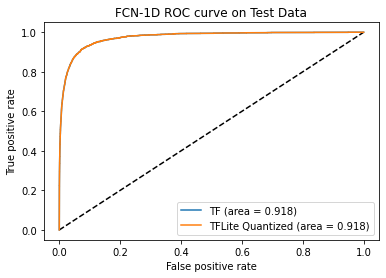

In [21]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr, tpr, label='TF (area = {:.3f})'.format(auc))
# plt.plot(fpr_nonquantized, tpr_nonquantized, label='TFLite Nonquantized (area = {:.3f})'.format(auc_tflite_nonquantized))
plt.plot(fpr_quantized, tpr_quantized, label='TFLite Quantized (area = {:.3f})'.format(auc_tflite_quantized))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(NN_ARCH + ' ROC curve on Test Data')
plt.legend(loc='best')
plt.savefig(MODELS_DIR + '/' + NN_ARCH + ' ROC curve on Test Data')
plt.show()

In [22]:
def get_size(path):
   
    #initialize the size
    total_size = 0
    
    #use the walk() method to navigate through directory tree
    for dirpath, dirnames, filenames in os.walk(path):
        for i in filenames:
            
            #use join to concatenate all the components of path
            f = os.path.join(dirpath, i)
            
            #use getsize to generate size in bytes and add it to the total size
            total_size += os.path.getsize(f)
    return total_size


size_tf = get_size(MODELS_DIR)
size_nonquan_tflite = os.stat(MODELS_DIR + '/' + NN_ARCH + '.tflite').st_size
size_tflite = os.stat(MODELS_DIR + '/' + NN_ARCH + '_quantized.tflite').st_size

In [23]:
print("TF:\n % 2.3f" %(size_tf/1048576.) + 'MB\n')
print("TFLite Non-quantized:\n % 2.3f" %(size_nonquan_tflite/1048576.) + 'MB\n')
print("TFLite Quantized:\n % 2.3f" %(size_tflite/1048576.) + 'MB\n')

TF:
  5.408MB

TFLite Non-quantized:
  1.084MB

TFLite Quantized:
  0.549MB



In [24]:
with open(MODELS_DIR + '/' + NN_ARCH + ' records.txt', 'a') as f:
    f.write('\n\n---------\n')
    f.write('FILE SIZE\n')
    f.write('TF:\n' +  str(size_tf/1048576.) + 'MB\n\n')
    f.write('TFLite Non-quantized:\n' +  str(size_nonquan_tflite/1048576.) + 'MB\n\n')
    f.write('TFLite Quantized:\n' +  str(size_tflite/1048576.) + 'MB\n\n')